# Apply PCM to ISAS dataset

Apply PCM method to ISAS dataset (example for a 3D gridded product). Notebook developped in __local__

In [1]:
import xarray as xr
import numpy as np

import pyxpcm
from pyxpcm.models import pcm

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import seaborn as sns

from Plotter import Plotter #new class for plots in pyxpcm

from PIL import Image, ImageFont

## User input
***

__Choose dataset__

In [2]:
# ISAS dataset
# TODO: file path template
file_path = '/home5/pharos/REFERENCE_DATA/OCEAN_REP/ISAS/ISAS15/ANA/ISAS_DT/ARGO_ONLY/2015/'

#time range
#TODO: more than 1 year
start_date = 20150115
end_date = 20150115
time_interval = 100 # TODO: easier way to get time interval, date type
# ISAS time interval is 1 month

#spatial extent
lon_extent = [-6,35]
lat_extent = [30,45]

# time and coordinates dimensions (expecify then here but use a generic name in the rest of the notebook)
time_dim = 'time'
lon_dim = 'longitude'
let_dim = 'latitude'
z_dim = 'depth'
temp_var = 'TEMP'

__Model options__

In [3]:
#Choise of z and pcm features (very important to make a good choise) 
z = np.arange(0.,-2000,-10.)
#z = ds['depth'][0:20]
pcm_features = {'temperature': z}

#classes
K=6

#fit
features_in_ds = {'temperature': temp_var}
features_zdim=z_dim

__Plot options__

## Get data
***

Open data files

<font color=red>__TODO__</font> : Only working with one year for the moment

<font color=red>__TODO__</font> : Only selecting data in mediterranean

In [4]:
# get list of paths
dates_range = np.arange(start_date, end_date + time_interval, time_interval)

ds_paths = []
for dt in dates_range:
    ds_paths.append([file_path + 'ISAS15_ARGO_' + str(dt) +'_fld_TEMP.nc'])

#open all data files
ds = xr.open_mfdataset(ds_paths,combine='by_coords', concat_dim=time_dim)

Select spatial extent

In [5]:
ds = ds.sel(latitude=slice(lat_extent[0],lat_extent[1]), longitude=slice(lon_extent[0], lon_extent[1])) 

In [ ]:
ds['depth'] = -np.abs(ds['depth'].values)
ds

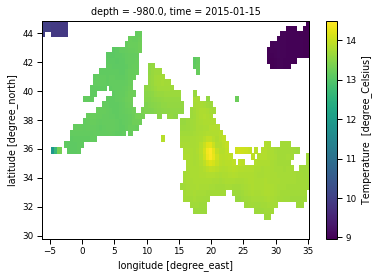

In [10]:
ds['TEMP'].isel(depth=100).plot();
#ds['TEMP'].isel(time=11, depth=100).plot();

<font color=red>__TODO__</font> : Use more tha TEMP variable

## Applying PCM
***

### Create PCM

In [11]:
m = pcm(K=K, features=pcm_features)
m

<pcm 'gmm' (K: 6, F: 1)>
Number of class: 6
Number of feature: 1
Feature names: odict_keys(['temperature'])
Fitted: False
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>

### Fit Model

In [12]:
m.fit(ds, features=features_in_ds, dim=features_zdim)
m

<pcm 'gmm' (K: 6, F: 1)>
Number of class: 6
Number of feature: 1
Feature names: odict_keys(['temperature'])
Fitted: True
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>
	 log likelihood of the training set: 23.217726

<font color=red>__TODO__</font> : save all trained PCM in a folder

In [ ]:
ds

### Classify data

In [ ]:
m.predict(ds, features=features_in_ds, dim=features_zdim, inplace=True);
ds

In [15]:
m.predict_proba(ds, features=features_in_ds, dim=features_zdim, inplace=True);

In [ ]:
ds = ds.pyxpcm.quantile(m, q=[0.05, 0.5, 0.95], of='TEMP', outname='TEMP' + '_Q', keep_attrs=True, inplace=True)
ds

In [ ]:
ds

## Visualisation
***

In [18]:
P = Plotter(ds.squeeze(), m, data_type = 'gridded')

#### 1. Vertical structure of classes

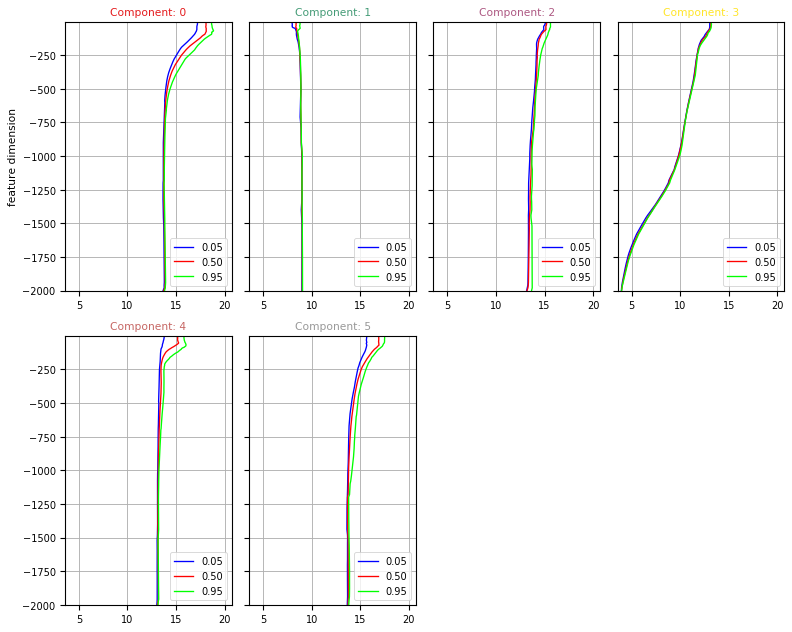

In [19]:
P.vertical_structure(q_variable = 'TEMP_Q')
#P.save_BlueCloud('figures/test_logos.png')

#### 2. Spatial distribution of classes

In [20]:
# Create a new plotter object and chose time step (is it the best idea?)
Ps = Plotter(ds.isel(time=0), m, data_type = 'gridded')

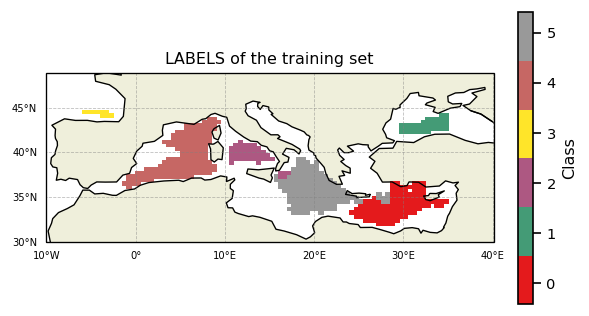

In [21]:
# Input should have only one time step
Ps.spatial_distribution(proj=ccrs.PlateCarree(), 
                        extent=np.array([-10,40,30,46]) + np.array([-0.1,+0.1,-0.1,+0.1]), 
                        co = {'latitude':'latitude', 'longitude':'longitude'})
Ps.save_BlueCloud('figures/test_logos.png')

#### 3. Posteriors

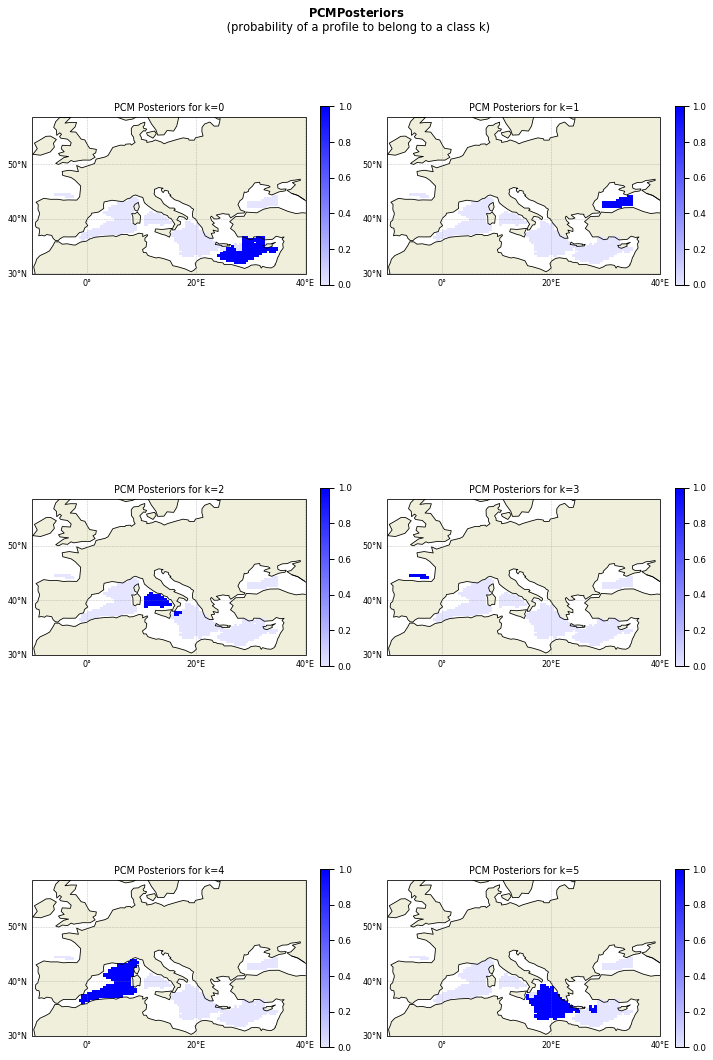

In [22]:
# Input should have only one time step
Ps.plot_posteriors(proj=ccrs.PlateCarree(), extent=np.array([-10,40,30,56]) + np.array([-0.1,+0.1,-0.1,+0.1]), 
                       co = {'latitude':'latitude', 'longitude':'longitude'})

#### 4. Temporal representation 

<font color=red>__TODO__</font> : Temporal representation in class plotter for 3D gridded data

Simple histogram

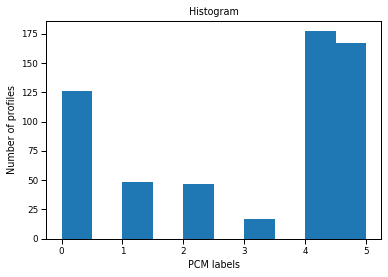

In [23]:
fig, axes = plt.subplots()
ds['PCM_LABELS'].plot.hist()
# y axis is number of profiles
axes.set_ylabel('Number of profiles')
plt.show()

Bar plot by __month__

In [ ]:
P.temporal_distribution(time_variable = 'time', time_bins = 'month', pond = 'abs')

Bar plot by __month__ (__relative__ number of profiles per month)

In [ ]:
P.temporal_distribution(time_variable = 'time', time_bins = 'month', pond = 'rel')

Bar plot by __season__

In [ ]:
P.temporal_distribution(time_variable = 'time', time_bins = 'season', pond = 'rel')